# FDA Drug Recall Enforcement Database & Data Analysis

Import the data first:

```shell
mongoimport --type csv -d recall_data_for_sql -c recall_list --headerline --drop recall_data_for_sql.csv
```

In [29]:
from pymongo import MongoClient
import pymongo
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [10]:
# Create an instance of MongoClient
mongo = MongoClient(port=27017)

In [11]:
# confirm that our new database was created
print(mongo.list_database_names())

['ClassDB', 'FruitDB', 'Fruits_db', 'admin', 'autosaurus', 'config', 'db', 'epa', 'local', 'met', 'recall_data_for_sql', 'test_database', 'travel_db', 'uk_food']


In [12]:
# assign the database to a variable name
db = mongo['recall_data_for_sql']

In [13]:
# review the collections in our new database
print(db.list_collection_names())

['recall_list']


In [14]:
# review a document in the customer_list collection
print(db.recall_list.find_one())

{'_id': ObjectId('65f8f13d2375e4636adcdee1'), 'Event_ID': 72241, 'Recalling_Firm': 'Kalman Health & Wellness, Inc. dba Essential Wellness Pharma', 'Substance_Name': "['na']", 'Product_Description': 'Progesterone 100 mg/mL in Corn Oil Injection, 2 mL vials, Rx only, Essential Wellness PHARMACY, 4625 N. University, Peoria, IL 61614.', 'Ingestion_Route': 'na', 'Reason': 'Lack of Assurance of Sterility', 'Classification': 'Class II', 'Quantity': '1 vial', 'Voluntary_Mandated': 'Voluntary: Firm initiated', 'Distribution': 'Nationwide', 'Initial_Notification_Method': 'Letter', 'Recall_Begins': '9/3/2015', 'Recall_End': '12/29/2017', 'Status': 'Terminated', 'City': 'Peoria', 'State': 'IL', 'Postal_Code': '61614-5828', 'Country': 'United States'}


In [38]:

pipeline = [
    {"$project": {"_id": 0, "keys": {"$objectToArray": "$$ROOT"}}},
    {"$unwind": "$keys"},
    {"$group": {"_id": None, "columns": {"$addToSet": "$keys.k"}}}
]

# Execute the aggregation pipeline
cursor = recall_list.aggregate(pipeline)

# Extracting columns
if cursor.alive:
    columns = next(cursor, {}).get('columns', [])
else:
    columns = []

print("Columns in the collection:")
for column in columns:
    print(column)

Columns in the collection:
Distribution
Quantity
Recall_End
Recalling_Firm
City
Postal_Code
Substance_Name
Ingestion_Route
Voluntary_Mandated
Recall_Begins
Status
Initial_Notification_Method
Country
State
Classification
Event_ID
Reason
_id
Product_Description


In [39]:
# assign the collection to a variable
recall_list = db['recall_list']

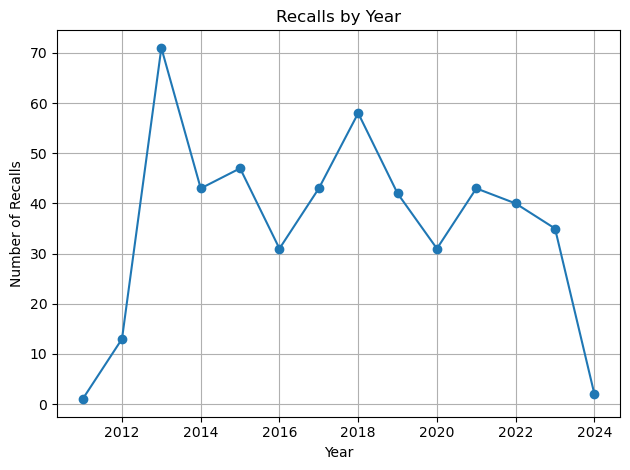

In [40]:
# MongoDB aggregation pipeline to group recalls by year
pipeline = [
    {
        "$group": {
            "_id": {"$year": {"$dateFromString": {"dateString": "$Recall_Begins"}}},
            "count": {"$sum": 1}
        }
    },
    {"$sort": {"_id": 1}}
]

# Execute the aggregation pipeline
cursor = recall_list.aggregate(pipeline)

# Extract data for plotting
years = []
counts = []
for doc in cursor:
    years.append(doc["_id"])
    counts.append(doc["count"])

# Plot the trend line
plt.plot(years, counts, marker='o')
plt.title('Recalls by Year')
plt.xlabel('Year')
plt.ylabel('Number of Recalls')
plt.grid(True)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


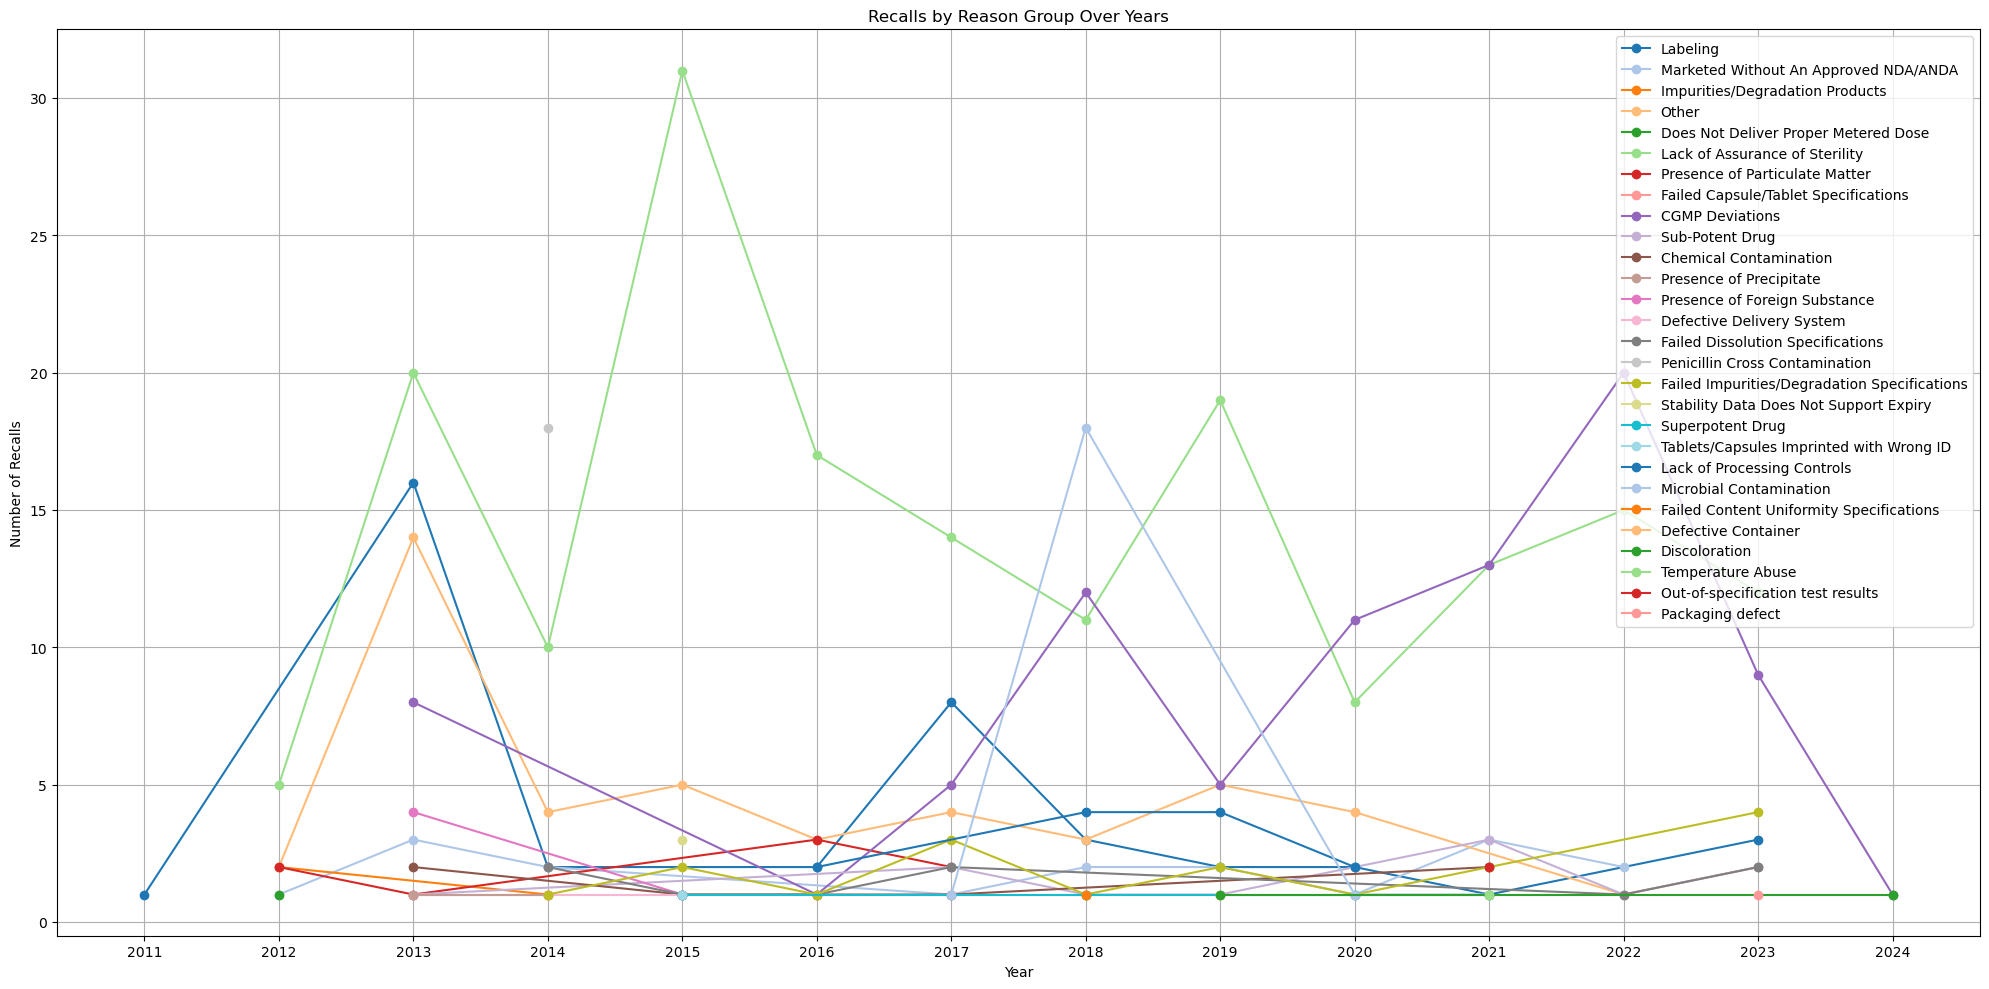

In [41]:
# MongoDB aggregation pipeline to group recalls by year and reason group
pipeline = [
    {
        "$project": {
            "Year": {"$year": {"$dateFromString": {"dateString": "$Recall_Begins"}}},
            "ReasonGroup": {
                "$switch": {
                    "branches": [
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Lack of Assurance of Sterility).*"}}, "then": "Lack of Assurance of Sterility"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(CGMP Deviations).*"}}, "then": "CGMP Deviations"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Presence of Particulate Matter).*"}}, "then": "Presence of Particulate Matter"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Penicillin Cross Contamination).*"}}, "then": "Penicillin Cross Contamination"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Temperature Abuse).*"}}, "then": "Temperature Abuse"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Presence of Foreign Substance).*"}}, "then": "Presence of Foreign Substance"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Failed Content Uniformity Specifications).*"}}, "then": "Failed Content Uniformity Specifications"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Defective Container).*"}}, "then": "Defective Container"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Failed Dissolution Specifications).*"}}, "then": "Failed Dissolution Specifications"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Marketed Without An Approved NDA/ANDA).*"}}, "then": "Marketed Without An Approved NDA/ANDA"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Discoloration).*"}}, "then": "Discoloration"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Lack of Processing Controls).*"}}, "then": "Lack of Processing Controls"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Failed Impurities/Degradation Specifications).*"}}, "then": "Failed Impurities/Degradation Specifications"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Failed Capsule/Tablet Specifications).*"}}, "then": "Failed Capsule/Tablet Specifications"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Microbial Contamination).*"}}, "then": "Microbial Contamination"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Tablets/Capsules Imprinted with Wrong ID).*"}}, "then": "Tablets/Capsules Imprinted with Wrong ID"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Stability Data Does Not Support Expiry).*"}}, "then": "Stability Data Does Not Support Expiry"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Chemical Contamination).*"}}, "then": "Chemical Contamination"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Defective Delivery System).*"}}, "then": "Defective Delivery System"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Presence of Precipitate).*"}}, "then": "Presence of Precipitate"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Does Not Deliver Proper Metered Dose).*"}}, "then": "Does Not Deliver Proper Metered Dose"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Superpotent Drug).*"}}, "then": "Superpotent Drug"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Out-of-specification test results).*"}}, "then": "Out-of-specification test results"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Sub-Potent Drug).*"}}, "then": "Sub-Potent Drug"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Impurities/Degradation Products).*"}}, "then": "Impurities/Degradation Products"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Labeling).*"}}, "then": "Labeling"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Packaging defect).*"}}, "then": "Packaging defect"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Labeling Incorrect Instructions).*"}}, "then": "Labeling Incorrect Instructions"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Labeling; Label Mix-up).*"}}, "then": "Labeling; Label Mix-up"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Labelling).*"}}, "then": "Labeling"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Labeling -label error on declared strength).*"}}, "then": "Labeling -label error on declared strength"},
                        {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Labeling; Incorrect or Missing Lot and/or Exp Date).*"}}, "then": "Labeling; Incorrect or Missing Lot and/or Exp Date"}
                    ],
                    "default": "Other"
                }
            }
        }
    },
    {
        "$group": {
            "_id": {"Year": "$Year", "ReasonGroup": "$ReasonGroup"},
            "count": {"$sum": 1}
        }
    },
    {"$sort": {"_id.Year": 1}}
]

# Execute the aggregation pipeline
cursor = recall_list.aggregate(pipeline)

import matplotlib.cm as cm

# Extract data for plotting
years = []
reason_groups = {}
colors = cm.tab20.colors  # Using a predefined colormap for distinct colors
color_index = 0
for doc in cursor:
    year = doc["_id"]["Year"]
    if year not in years:
        years.append(year)
    reason_group = doc["_id"]["ReasonGroup"]
    count = doc["count"]
    if reason_group not in reason_groups:
        reason_groups[reason_group] = {"counts": [], "label": reason_group, "color": colors[color_index]}
        color_index = (color_index + 1) % len(colors)
    reason_groups[reason_group]["counts"].append((year, count))

# Plot the trend line for each reason group
plt.figure(figsize=(20, 10))
for group, data in reason_groups.items():
    data["counts"].sort(key=lambda x: x[0])  # Sort by year
    x = [entry[0] for entry in data["counts"]]
    y = [entry[1] for entry in data["counts"]]
    plt.plot(x, y, marker='o', label=data["label"], color=data["color"])

plt.title('Recalls by Reason Group Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Recalls')
plt.grid(True)
plt.xticks(years, rotation=0)
plt.legend()
plt.tight_layout()
plt.show()




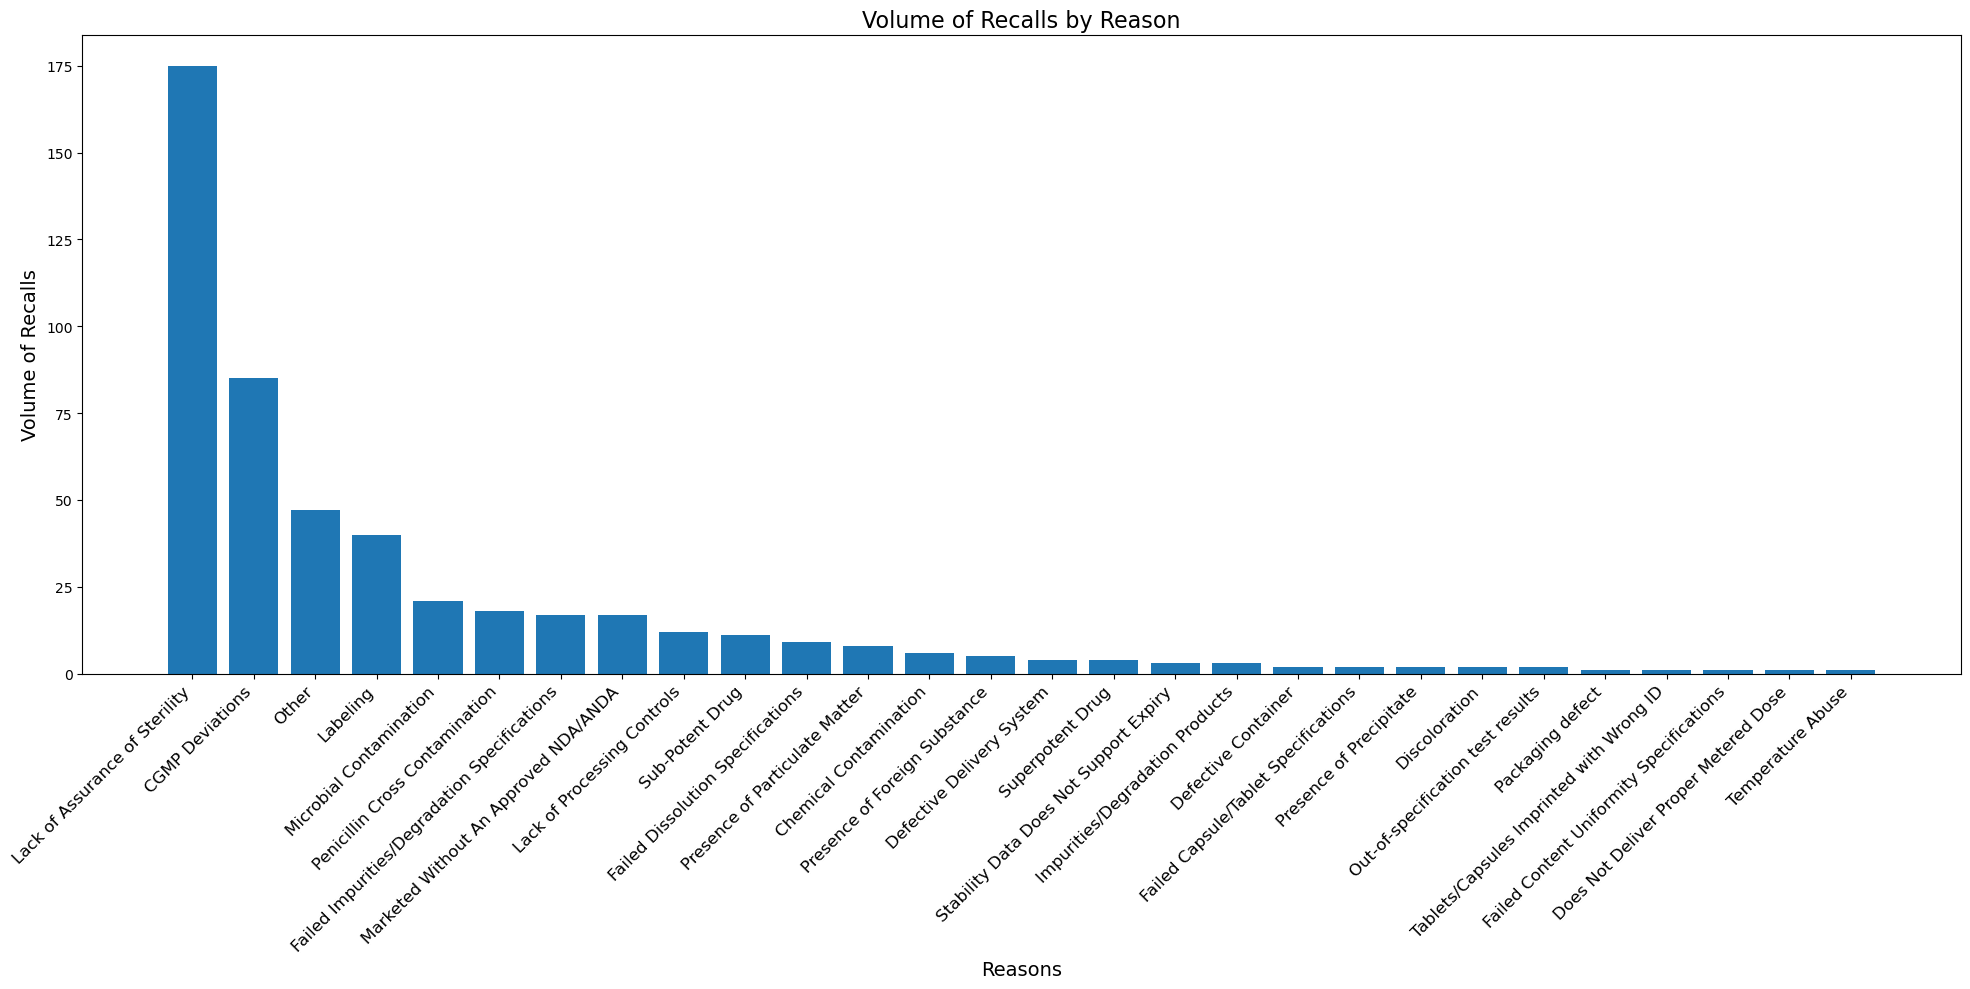

In [42]:
# Define mapping of reasons to groups
reason_groups = {
    "Reason Group 1": ["Reason 1", "Reason 2", "Reason 3"],
    "Reason Group 2": ["Reason 4", "Reason 5"]
    # Add more mappings as needed
}

# MongoDB aggregation pipeline to group recalls by reason
pipeline = [
  {
    "$project": {
      "ReasonGroup": {
        "$switch": {
          "branches": [
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Lack of Assurance of Sterility).*"}}, "then": "Lack of Assurance of Sterility"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(CGMP Deviations).*"}}, "then": "CGMP Deviations"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Presence of Particulate Matter).*"}}, "then": "Presence of Particulate Matter"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Penicillin Cross Contamination).*"}}, "then": "Penicillin Cross Contamination"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Temperature Abuse).*"}}, "then": "Temperature Abuse"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Presence of Foreign Substance).*"}}, "then": "Presence of Foreign Substance"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Failed Content Uniformity Specifications).*"}}, "then": "Failed Content Uniformity Specifications"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Defective Container).*"}}, "then": "Defective Container"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Failed Dissolution Specifications).*"}}, "then": "Failed Dissolution Specifications"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Marketed Without An Approved NDA/ANDA).*"}}, "then": "Marketed Without An Approved NDA/ANDA"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Discoloration).*"}}, "then": "Discoloration"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Lack of Processing Controls).*"}}, "then": "Lack of Processing Controls"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Failed Impurities/Degradation Specifications).*"}}, "then": "Failed Impurities/Degradation Specifications"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Failed Capsule/Tablet Specifications).*"}}, "then": "Failed Capsule/Tablet Specifications"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Microbial Contamination).*"}}, "then": "Microbial Contamination"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Tablets/Capsules Imprinted with Wrong ID).*"}}, "then": "Tablets/Capsules Imprinted with Wrong ID"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Stability Data Does Not Support Expiry).*"}}, "then": "Stability Data Does Not Support Expiry"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Chemical Contamination).*"}}, "then": "Chemical Contamination"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Defective Delivery System).*"}}, "then": "Defective Delivery System"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Presence of Precipitate).*"}}, "then": "Presence of Precipitate"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Does Not Deliver Proper Metered Dose).*"}}, "then": "Does Not Deliver Proper Metered Dose"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Superpotent Drug).*"}}, "then": "Superpotent Drug"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Out-of-specification test results).*"}}, "then": "Out-of-specification test results"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Sub-Potent Drug).*"}}, "then": "Sub-Potent Drug"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Impurities/Degradation Products).*"}}, "then": "Impurities/Degradation Products"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Labeling).*"}}, "then": "Labeling"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Packaging defect).*"}}, "then": "Packaging defect"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Labeling Incorrect Instructions).*"}}, "then": "Labeling Incorrect Instructions"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Labeling; Label Mix-up).*"}}, "then": "Labeling; Label Mix-up"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Labelling).*"}}, "then": "Labeling"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Labeling -label error on declared strength).*"}}, "then": "Labeling -label error on declared strength"},
            {"case": {"$regexMatch": {"input": "$Reason", "regex": ".*(Labeling; Incorrect or Missing Lot and/or Exp Date).*"}}, "then": "Labeling; Incorrect or Missing Lot and/or Exp Date"}
          ],
          "default": "Other"
        }
      }
    }
  },
  {
    "$group": {
      "_id": "$ReasonGroup",
      "count": { "$sum": 1 }
    }
  }
]


# Execute the aggregation pipeline
cursor = recall_list.aggregate(pipeline)

# Extract data for plotting
reason_groups = []
counts = []
for doc in cursor:
    reason_groups.append(doc["_id"])
    counts.append(doc["count"])

# Sort reason_groups and counts based on counts in descending order
reason_groups, counts = zip(*sorted(zip(reason_groups, counts), key=lambda x: x[1], reverse=True))

# Plot the bar graph
plt.figure(figsize=(20, 10))  
plt.bar(reason_groups, counts)

# Adjusting the appearance of the plot
plt.xticks(rotation=45, ha='right', fontsize=12)  
plt.yticks(fontsize=10)  
plt.xlabel('Reasons', fontsize=14)  
plt.ylabel('Volume of Recalls', fontsize=14)  
plt.title('Volume of Recalls by Reason', fontsize=16)  
plt.tight_layout() 
plt.show()



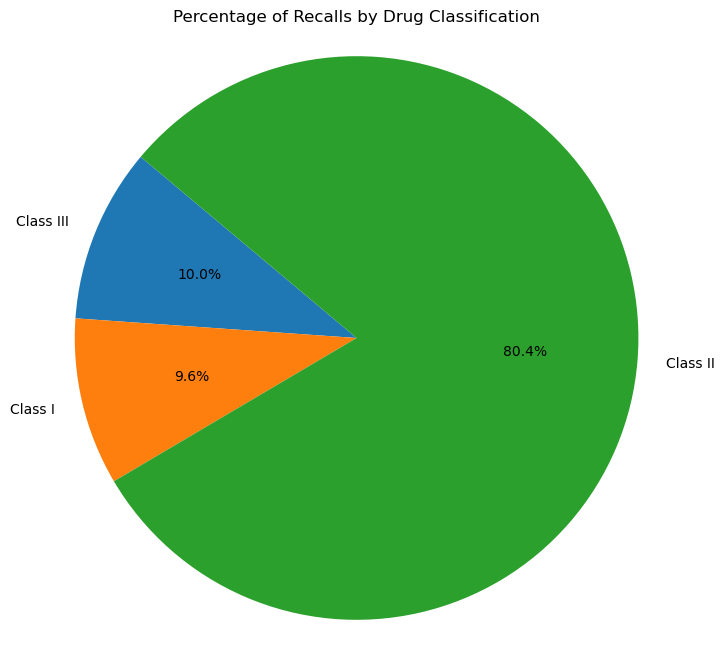

In [43]:
# MongoDB aggregation pipeline to calculate the count of recalls by classification
pipeline = [
    {
        "$group": {
            "_id": "$Classification",
            "count": {"$sum": 1}
        }
    }
]

# Execute the aggregation pipeline
cursor = recall_list.aggregate(pipeline)

# Extract data for plotting
classifications = []
counts = []
for doc in cursor:
    classifications.append(doc["_id"])
    counts.append(doc["count"])

# Calculate the total count of recalls in the dataset
total_recalls = sum(counts)

# Calculate the percentages
percentages = [(count / total_recalls) * 100 for count in counts]

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(percentages, labels=classifications, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Recalls by Drug Classification')
plt.axis('equal') 
plt.show()


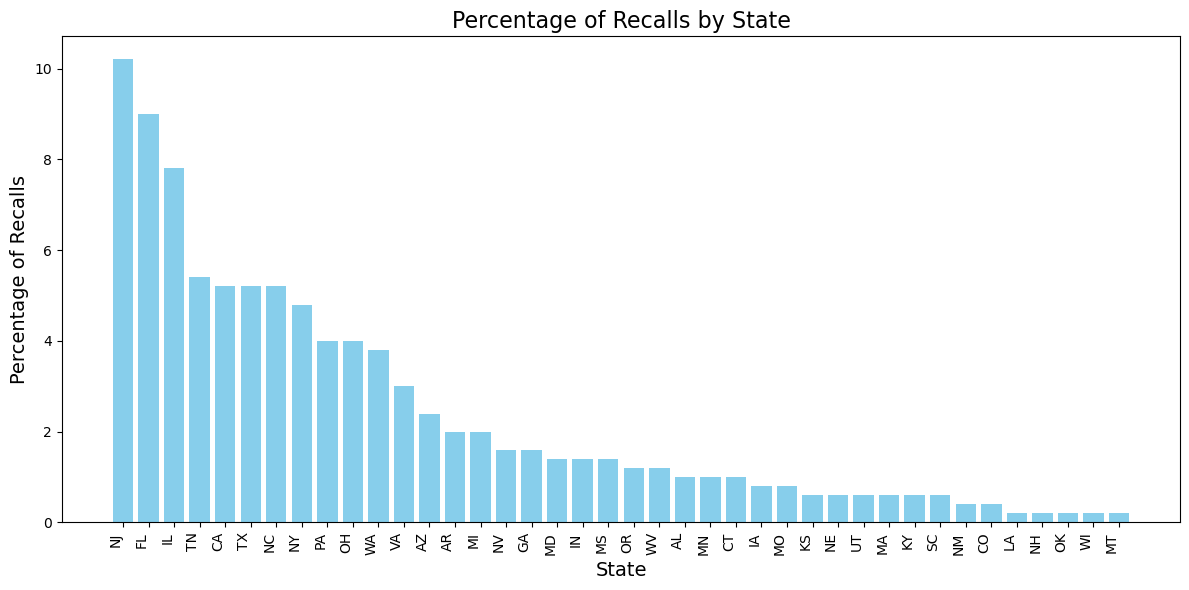

In [44]:
# MongoDB aggregation pipeline to calculate the percentage of recalls by state and sort them. This excludes recalls that don't have State populated.
pipeline = [
    {
        "$match": {
            "State": {"$ne": ""}  # Exclude documents with empty state field
        }
    },
    {
        "$group": {
            "_id": "$State",
            "count": { "$sum": 1 }
        }
    },
    {
        "$project": {
            "_id": 0,
            "State": "$_id",
            "Count": 1,
            "Percentage": { "$multiply": [{ "$divide": ["$count", 500] }, 100] }
        }
    },
    {
        "$sort": {"Percentage": -1}  # Sort in descending order based on percentage
    }
]

# Execute the aggregation pipeline
cursor = recall_list.aggregate(pipeline)

# Extract data for plotting
states = []
percentages = []
for doc in cursor:
    states.append(doc["State"])
    percentages.append(doc["Percentage"])

# Plot the bar graph
plt.figure(figsize=(12, 6))
plt.bar(states, percentages, color='skyblue')
plt.xlabel('State', fontsize=14)
plt.ylabel('Percentage of Recalls', fontsize=14)
plt.title('Percentage of Recalls by State', fontsize=16)
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()



C:\Users\emily\AppData\Local\Temp\ipykernel_18100\3152850912.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


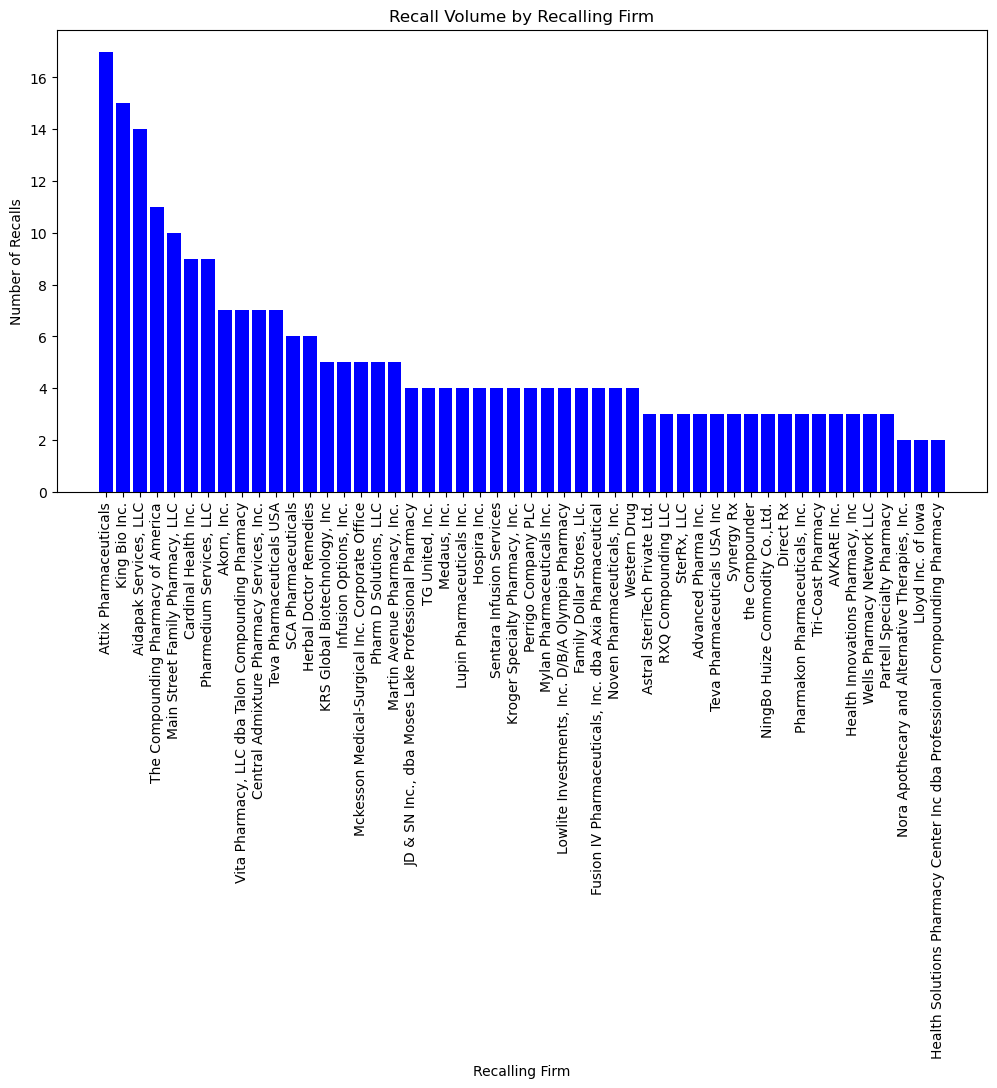

In [58]:
# Aggregation pipeline to group recalls by recalling firm and limit to top 25
pipeline = [
    {
        "$group": {
            "_id": "$Recalling_Firm",  # Group by recalling firm
            "totalRecalls": {"$sum": 1}  # Count the number of recalls in each group
        }
    },
    {"$sort": {"totalRecalls": -1}},  # Sort by total recalls in descending order
    {"$limit": 50}  # Limit to top 25 recalling firms
]

# Execute the aggregation pipeline
cursor = recall_list.aggregate(pipeline)

# Extracting data for plotting
recalling_firms = []
total_recalls = []

for doc in cursor:
    recalling_firms.append(doc['_id'])
    total_recalls.append(doc['totalRecalls'])

# Create bar chart
plt.figure(figsize=(12, 6))
plt.bar(recalling_firms, total_recalls, color='blue')
plt.xlabel('Recalling Firm')
plt.ylabel('Number of Recalls')
plt.title('Recall Volume by Recalling Firm')
plt.xticks(rotation=90)  
plt.tight_layout()  
plt.show()

